# Model calibration
This notebook contains a calibration of the model for the current number of agents. Usually ABMs are not linearly scalable and therefore this procedure should be followed for model calibration, to avoid unnecessary long start-up time of the model and thus a wastage of computing power. Because the RIVM stakeholders mentioned during one of the final meetings that they were especially interested in the process of model-building, this notebook is an annex to assist for when the model is built. Note that in case this model will be extended, this notebook will require to be extended, since it only includes current variables. However, most certainly the process stays the same.

Calibration outcomes of the model need to be implemented directly in the agents manually. Due to ABMs being stochastic, initial values will not be perfect but provide a good starting point. First we will be importing the model in the notebook and set it up in such a way that all policies and scenarios are turned off to see whether we can get the model in some sort of equilibrium.

In [1]:
from model.cepai_model import *

levers = {
    "L1": 0.0,  # Minimal requirement for reused parts
    "L2": 0.0,  # Minimal requirement for high-quality plastic
    "L3": 0.0,  # Use better solvable cohesives
    "L4": 1.0,  # Include externality for virgin plastic
    "L5": 0.05   # Minimal requirement for recyclate, calibrated for 5% according to Volvo.
        }

uncertainties = {
    "X1": 0.0,  # Annual increase factor of oil price
    "X2": 0.0,  # Annual probability for global oil shock
    "X3": 0.0   # Annual increase of recycling efficiency
        }

In [2]:
model = CEPAIModel(levers=levers, uncertainties=uncertainties)

Simulation starting...


In [3]:
stabilisation_steps = 150
model_stabilisation_run = model.run(steps=stabilisation_steps, time_tracking=True, debug=True)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
Step: 110


And next we will run steps for gathering mean data to provide a good starting point for the experimental model runs. There are multiple things we need initial values for: stocks and demands. For garages we will not initially set up stocks with cars, as these belong to users and this will unnecessarily complicate the process.

In [4]:
def get_stocks(agent):
    agent_stocks = {}

    for comp, stocks in agent.stock.items():
        if isinstance(stocks, (float or int)):
            agent_stocks[comp] = stocks
        elif isinstance(stocks, list):
            agent_stocks[comp] = len(stocks)

    return agent_stocks

In [5]:
import collections
import pandas as pd

calibration_steps = 50

data = []

for _ in range(calibration_steps):
    """
    Collect every step of the model the values for stocks and demands of all agent classes except users and refiners and save them in a Pandas dataframe.
    """
    # Garages, check both demand and stock
    i = 0

    for garage in model.all_agents[Garage]:
        if i == 0:
            garage_stocks  = get_stocks(garage)
            garage_demands = garage.demand
            i += 1
        else:
            garage_stock_to_add = get_stocks(garage)
            garage_stocks = dict(collections.Counter(garage_stocks) + collections.Counter(garage_stock_to_add))
            garage_demands = dict(collections.Counter(garage_demands) + collections.Counter(garage.demand))
            i += 1

        garage_stocks = {k: v / i for k, v in garage_stocks.items()}
        garage_demands = {k: v / i for k, v in garage_demands.items()}

    # Parts manufacturers, check both demand and stock
    i = 0

    for PM in model.all_agents[PartsManufacturer]:
        if i == 0:
            PM_stocks = get_stocks(PM)
            PM_demands = PM.demand
            i += 1
        else:
            PM_stock_to_add = get_stocks(PM)
            PM_stocks = dict(collections.Counter(PM_stocks) + collections.Counter(PM_stock_to_add))
            PM_demands = dict(collections.Counter(PM_demands) + collections.Counter(PM.demand))
            i += 1

        PM_stocks = {k: v / i for k, v in PM_stocks.items()}
        PM_demands = {k: v / i for k, v in PM_demands.items()}

    # Car manufacturers, check both demand and stock
    i = 0

    for CM in model.all_agents[CarManufacturer]:
        if i == 0:
            CM_stocks = get_stocks(CM)
            CM_demands = CM.demand
            i += 1
        else:
            CM_stock_to_add = get_stocks(CM)
            CM_stocks = dict(collections.Counter(CM_stocks) + collections.Counter(CM_stock_to_add))
            CM_demands = dict(collections.Counter(CM_demands) + collections.Counter(CM.demand))
            i += 1

        CM_stocks = {k: v / i for k, v in CM_stocks.items()}
        CM_demands = {k: v / i for k, v in CM_demands.items()}

    # Dismantlers, check stock
    i = 0

    for dismantler in model.all_agents[Dismantler]:
        if i == 0:
            dismantler_stocks = get_stocks(dismantler)
            i += 1
        else:
            dismantler_stock_to_add = get_stocks(dismantler)
            dismantler_stocks = dict(collections.Counter(dismantler_stocks) + collections.Counter(dismantler_stock_to_add))
            i += 1

        garage_stocks = {k: v / i for k, v in dismantler_stocks.items()}

    # Recyclers, check stock
    i = 0

    for recycler in model.all_agents[Recycler]:
        if i == 0:
            recycler_stocks = get_stocks(recycler)
            i += 1
        else:
            recycler_stock_to_add = get_stocks(recycler)
            recycler_stocks = dict(collections.Counter(recycler_stocks) + collections.Counter(recycler_stock_to_add))
            i += 1

        recycler_stocks = {k: v / i for k, v in recycler_stocks.items()}

    # Update the dataframes
    update_list = [garage_stocks, garage_demands, PM_stocks, PM_demands, CM_stocks, CM_demands, dismantler_stocks, recycler_stocks]
    data.append(update_list)

    # And advance the model one step again.
    model.step()
    print(f'Step: {_}')

columns = ['Garage_stock', 'Garage_demand',
           'PartsManufacturer_stock', 'PartsManufacturer_demand',
           'CarManufacturer_stock', 'CarManufacturer_demand',
           'Dismantler_stock',
           'Recycler_stock']
calibration_df = pd.DataFrame(data=data, columns=columns)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49


In [6]:
model_reporters = model.datacollector.get_model_vars_dataframe()
model_reporters.head()

,amount virgin,amount recyclate high,amount recyclate low,amount reused parts,amount standard parts,cars in garage,amount leakage,price virgin,price recyclate
0,3084.311132,183.688868,0.000000,273,3727,183,0.000000,2.266979,2.739481
1,3465.903428,200.909376,5.187196,263,3409,0,0.000000,2.562875,2.468755
2,3582.552032,204.675449,8.772520,246,3550,0,0.000000,2.905782,2.690383
3,3525.844772,201.600052,8.555176,295,3489,12,0.000000,3.001294,2.679595
4,3314.421649,186.383883,11.194468,296,3452,59,0.106952,3.346926,3.269199


In [7]:
import matplotlib.pyplot as plt

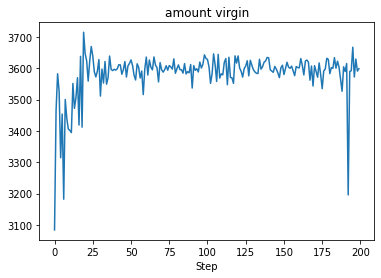

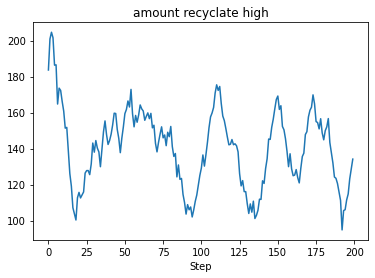

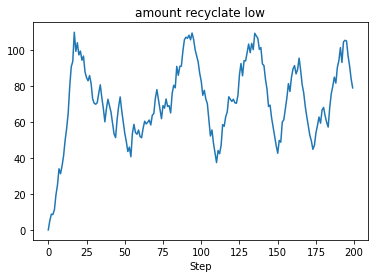

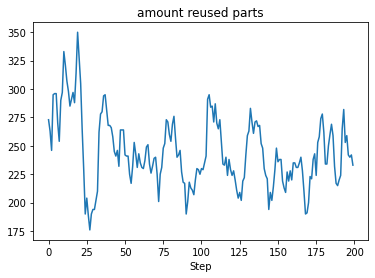

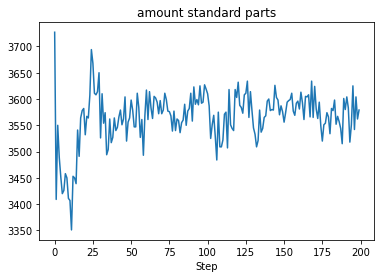

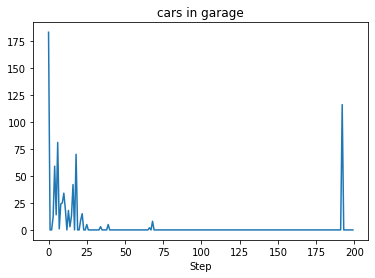

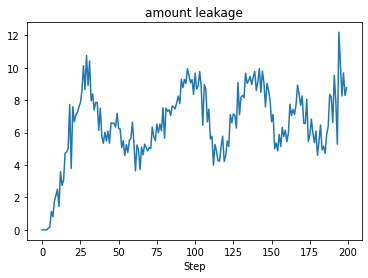

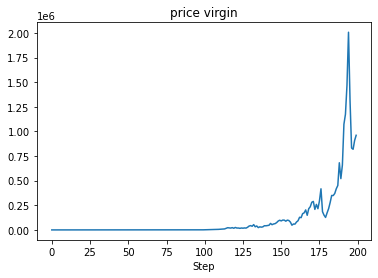

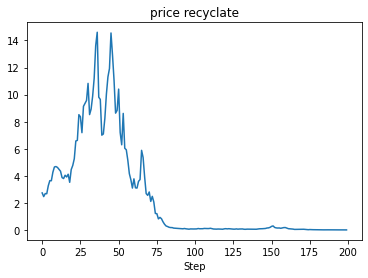

In [8]:
for column in model_reporters:
    plt.figure()
    plt.plot(model_reporters[column])
    plt.title(column)
    plt.xlabel("Step")
    plt.ylabel("")

See below a brief overview of the (mean) individual demands and stocks of the last 50 steps.

In [9]:
def count_agent_type(agent):
    if agent == 'Garage':
        agent_qt = len(model.all_agents[Garage])
    elif agent == 'PartsManufacturer':
        agent_qt = len(model.all_agents[PartsManufacturer])
    elif agent == 'CarManufacturer':
        agent_qt = len(model.all_agents[CarManufacturer])
    elif agent == 'Dismantler':
        agent_qt = len(model.all_agents[Dismantler])
    elif agent == 'Recycler':
        agent_qt = len(model.all_agents[Recycler])

    return agent_qt

In [10]:
import math

n_steps = len(calibration_df)

means_column = {}
means_ceiled_column = {}

# For every column
for column in calibration_df:

    # Retrieve means of the calibration steps and save in another dataframe.
    mean_steps = {}

    for step in calibration_df[column]:
        mean_steps = dict(collections.Counter(mean_steps) + collections.Counter(step))

    mean_steps = {k: v / n_steps for k, v in mean_steps.items()}

    # Retrieve means per agent
    agent_type_and_stock_or_demand = column.split(sep="_")
    agent_type = agent_type_and_stock_or_demand[0]
    stock_or_demand = agent_type_and_stock_or_demand[1]

    nr_of_agents = count_agent_type(agent_type)

    mean_agent_steps = {k: round(v) / nr_of_agents for k, v in mean_steps.items()}
    mean_ceiled_agent_steps = {}
    for k, v in mean_agent_steps.items():
        rounded_to_10 = math.ceil(v/10) * 10
        mean_ceiled_agent_steps[k] = rounded_to_10

    means_column[column] = mean_agent_steps
    means_ceiled_column[column] = mean_ceiled_agent_steps

    print("Every {agent_type} should have the following values for their {stock_or_demand}: {mean_agent_steps}".format(agent_type=agent_type, stock_or_demand=stock_or_demand,mean_agent_steps=mean_ceiled_agent_steps))

Every Garage should have the following values for their stock: {<Component.PARTS_FOR_RECYCLER: 5>: 10, <Component.PARTS: 4>: 20}
Every Garage should have the following values for their demand: {<Component.PARTS: 4>: 60}
Every PartsManufacturer should have the following values for their stock: {<Component.VIRGIN: 1>: 10, <Component.RECYCLATE_HIGH: 3>: 0, <Component.PARTS: 4>: 500, <Component.RECYCLATE_LOW: 2>: 0}
Every PartsManufacturer should have the following values for their demand: {<Component.VIRGIN: 1>: 50, <Component.RECYCLATE_LOW: 2>: 10, <Component.PARTS: 4>: 50}
Every CarManufacturer should have the following values for their stock: {<Component.PARTS: 4>: 10, <Component.CARS: 6>: 50}
Every CarManufacturer should have the following values for their demand: {<Component.PARTS: 4>: 110, <Component.CARS: 6>: 30}
Every Dismantler should have the following values for their stock: {<Component.PARTS_FOR_RECYCLER: 5>: 10, <Component.PARTS: 4>: 40}
Every Recycler should have the followi

In [11]:
print(means_column)

{'Garage_stock': {<Component.PARTS_FOR_RECYCLER: 5>: 1.5, <Component.PARTS: 4>: 16.5}, 'Garage_demand': {<Component.PARTS: 4>: 52.0}, 'PartsManufacturer_stock': {<Component.VIRGIN: 1>: 5.666666666666667, <Component.RECYCLATE_HIGH: 3>: 0.0, <Component.PARTS: 4>: 496.0, <Component.RECYCLATE_LOW: 2>: 0.0}, 'PartsManufacturer_demand': {<Component.VIRGIN: 1>: 43.0, <Component.RECYCLATE_LOW: 2>: 2.6666666666666665, <Component.PARTS: 4>: 45.666666666666664}, 'CarManufacturer_stock': {<Component.PARTS: 4>: 0.25, <Component.CARS: 6>: 46.5}, 'CarManufacturer_demand': {<Component.PARTS: 4>: 100.5, <Component.CARS: 6>: 25.25}, 'Dismantler_stock': {<Component.PARTS_FOR_RECYCLER: 5>: 3.0, <Component.PARTS: 4>: 33.0}, 'Recycler_stock': {<Component.RECYCLATE_LOW: 2>: 13.0, <Component.RECYCLATE_HIGH: 3>: 56453.0}}


Averages are shown in red and the blue line indicates the value rounded up to a multiple of ten, for simplicity when entering default values.


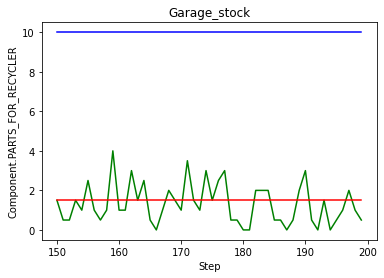

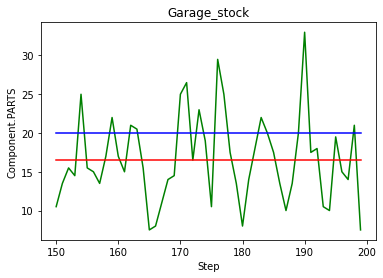

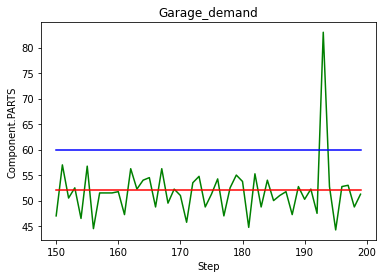

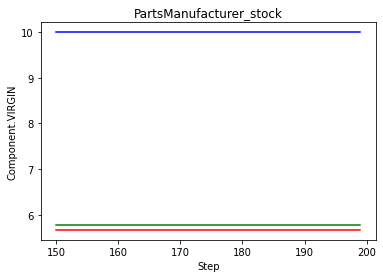

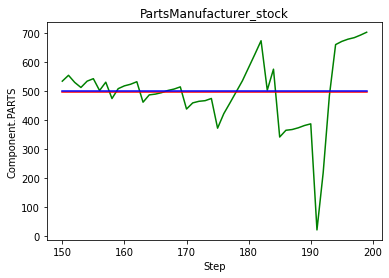

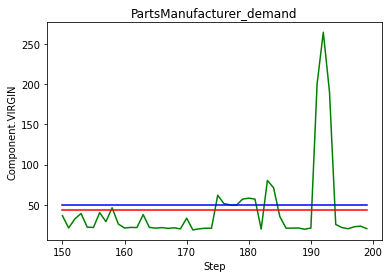

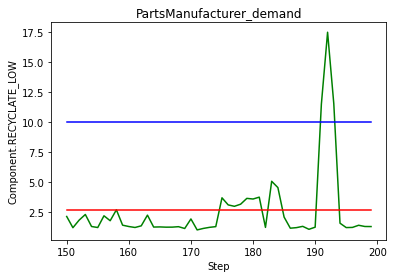

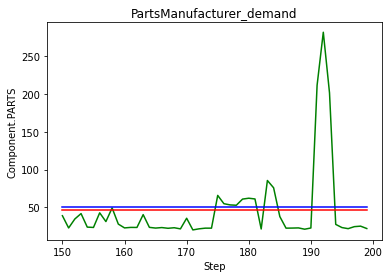

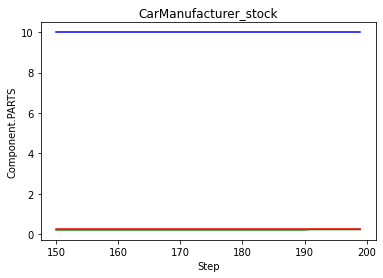

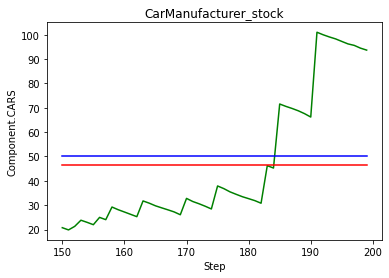

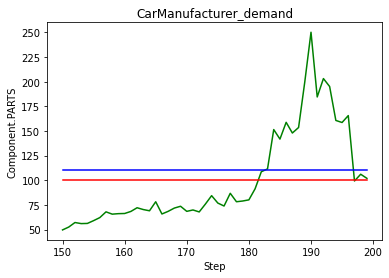

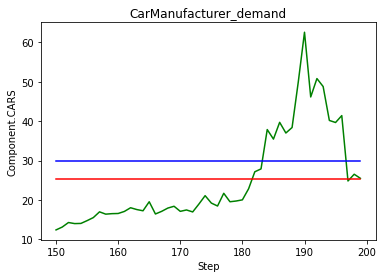

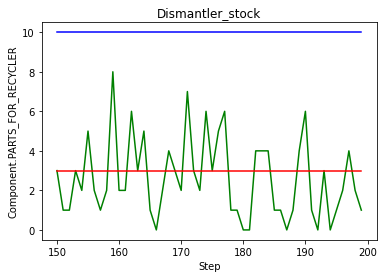

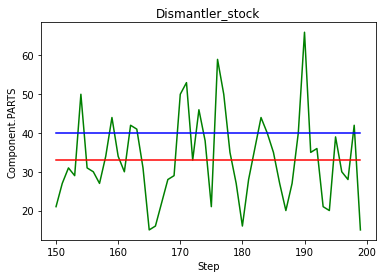

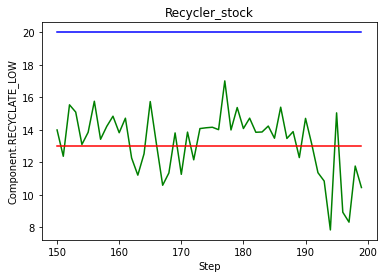

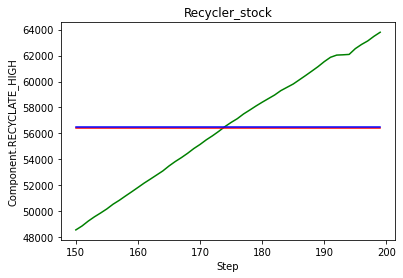

In [12]:
import matplotlib.pyplot as plt

print("Averages are shown in red and the blue line indicates the value rounded up to a multiple of ten, for simplicity when entering default values.")

for column in calibration_df:
    dictionary = calibration_df[column].iloc[0]
    relevant = []

    for k, v in dictionary.items():
        if round(v) > 0.0:
            relevant.append(k)

    dictionary_relevant = {k: dictionary[k] for k in relevant}

    for component in dictionary_relevant.keys():
        x = list(calibration_df.index)
        data_list = []
        mean = means_column[column][component]
        mean_list = [mean for step in x]
        mean_ceiled = means_ceiled_column[column][component]
        mean_ceiled_list = [mean_ceiled for step in x]

        for step in x:
            data_list.append(calibration_df[column].iloc[step][component])

            # Retrieve means per agent
        agent_type_and_stock_or_demand = column.split(sep="_")
        agent_type = agent_type_and_stock_or_demand[0]
        stock_or_demand = agent_type_and_stock_or_demand[1]

        nr_of_agents = count_agent_type(agent_type)

        data_list = [x / nr_of_agents for x in data_list]
        x = [element + stabilisation_steps for element in x]

        plt.figure()
        plt.plot(x, data_list, 'g')
        plt.plot(x, mean_list, 'r')
        plt.plot(x, mean_ceiled_list, 'b')
        plt.title(column)
        plt.xlabel("Step")
        plt.ylabel(component)


Note that stocks of plastic resources should be floats when used as inputs. For parts manufacturers there currently is an excess amount of stock of parts due to the current non-rigid supply chain relations and should be reduced to a reasonable number. Also recycler high quality recyclate stock needs to be reduced, because the current supply chain does not use enough recyclate to deplete that stock. Furthermore, adjust the CarManufacturer default demand in such way that the number of users is divided by the car lifetime.

A good measure to see whether the model runs correctly or that parameters need to be changed is the metric specified below. There should not be too many cars in the garage, which indicates a parts shortage or too many users demanding a car, which indicates a car shortage (and possibly indirect a parts shortage). However, current non-rigidity of the supply chains may cause this behaviour. Implementation of more rigid supplier and buyer relations will solve this issue.

In [13]:
car_possession = 0
car_demand = 0
cars_in_garage = 0

for user in model.all_agents[User]:
    if user.stock[Component.CARS]:
        car_possession += 1
    elif user.demand[Component.CARS] == 1:
        car_demand += 1
    else:
        cars_in_garage += 1

ratio_initial_cars = round((car_possession + cars_in_garage) / (car_possession + cars_in_garage + car_demand),2)

print(f'There are {car_possession} cars in use.')
print(f'There is demand for {car_demand} cars.')
print(f'There are {cars_in_garage} cars in the garage.')
print(f'The ratio of initial users possessing a car should be {ratio_initial_cars} and should be updated in the cepai_model.py file.')

There are 953 cars in use.
There is demand for 47 cars.
There are 0 cars in the garage.
The ratio of initial users possessing a car should be 0.95 and should be updated in the cepai_model.py file.
